In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
df = pd.read_csv("input/data-salary.txt")
print(df.head(1))
print(df.shape)
X = df.X.values
y = df.Y.values
N = df.shape[0]

    X    Y
0  24  472
(20, 2)


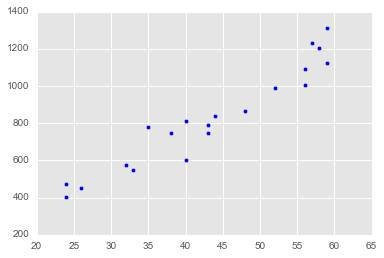

In [3]:
plt.scatter(X, y)

In [4]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
res_lm = smf.ols('Y ~ X', data=df).fit()
res_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     208.2
Date:                Thu, 10 Nov 2016   Prob (F-statistic):           2.47e-11
Time:                        01:39:32   Log-Likelihood:                -114.74
No. Observations:                  20   AIC:                             233.5
Df Residuals:                      18   BIC:                             235.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   -119.6971     68.148     -1.756      0.096      -262.871    23.477
X             21.9042      1.518     14.428      0.000        18.715    25.094
==============================================================================
Omnibus:                        0.099   Durbin-Watson:                   2.252
Prob(Omnibus):                  0.952   Jarque-Bera (JB):                0.216
Skew:                           0.140   Prob(JB):                        0.898
Kurtosis:                       2.575   Cond. No.                         173.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [5]:
from statsmodels.stats.outliers_influence import summary_table
st, data, _ = summary_table(res_lm, alpha=0.05)
st5, data5, _ = summary_table(res_lm, alpha=0.5)

In [6]:
st

Obs,Dep Var,Predicted,Std Error,Mean ci,Mean ci,Predict ci,Predict ci,Residual,Std Error,Student,Cook's
,Population,Value,Mean Predict,95% low,95% upp,95% low,95% upp,,Residual,Residual,D
1.0,472.0,406.003702271,34.2902643298,333.962530175,478.044874367,224.879500963,587.127903579,65.9962977289,71.2799011262,0.925875270394,0.0991933281345
2.0,403.0,406.003702271,34.2902643298,333.962530175,478.044874367,224.879500963,587.127903579,-3.00370227109,71.2799011262,-0.0421395403702,0.000205474097501
3.0,454.0,449.812105137,31.7276820162,383.154718703,516.469491571,270.761126395,628.863083879,4.18789486287,72.4568887425,0.0577984362225,0.000320272394109
4.0,575.0,581.237313735,24.6931088237,529.359017166,633.115610305,407.147097246,755.327530225,-6.23731373524,75.1458376026,-0.0830027841093,0.00037196065654
5.0,546.0,603.141515168,23.6587034885,553.436423566,652.846606771,429.686500961,776.596529375,-57.1415151683,75.4778926681,-0.75706293788,0.0281563481188
6.0,781.0,646.949918034,21.7608051505,601.23216288,692.667673188,474.595170613,819.304665456,134.050081966,76.0467875165,1.76273168589,0.127212738556
7.0,750.0,712.662522333,19.4628637173,671.772562983,753.552481683,541.525049529,883.799995138,37.3374776666,76.6670950819,0.487007856849,0.00764253447968
8.0,601.0,756.470925199,18.4037651513,717.80604937,795.135801029,585.851411528,927.09043887,-155.470925199,76.928200035,-2.02098742891,0.116879797885
9.0,814.0,756.470925199,18.4037651513,717.80604937,795.135801029,585.851411528,927.09043887,57.5290748006,76.928200035,0.747828166712,0.0160035328303


In [7]:
predicted_value = data[:,2].T
mean_ci_low, mean_ci_upp = data[:,4:6].T
predict_ci_low, predict_ci_upp = data[:,6:8].T

#### confidence interval

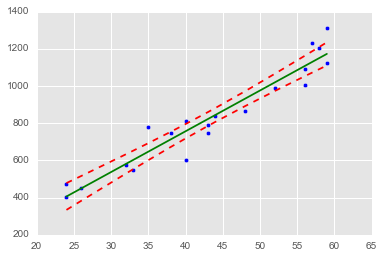

In [8]:
plt.scatter(X, y)
plt.plot(X, predicted_value, '-', color='g')
plt.plot(X, mean_ci_low, '--', color='r')
plt.plot(X, mean_ci_upp, '--', color='r')

#### prediction interval

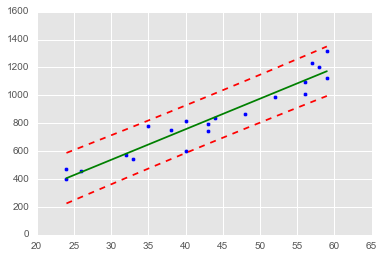

In [9]:
plt.scatter(X, y)
plt.plot(X, predicted_value, '-', color='g')
plt.plot(X, predict_ci_low, '--', color='r')
plt.plot(X, predict_ci_upp, '--', color='r')

### 4.4.5 stanで実装

In [10]:
import pystan
stan_data = {'N':N, 'X':X, 'Y': y}
fit = pystan.stan(file='input/model4-5.stan', data=stan_data, seed=1234)

In [11]:
fit

Inference for Stan model: anon_model_b434bb1e5d9d51500bfdc976c8c173bc.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a     -123.4    3.24  73.86 -264.7 -172.1 -123.6 -76.07  25.18    520    1.0
b      21.98    0.07   1.64  18.73  20.94  21.99  23.07   25.1    517    1.0
sigma  84.96     0.6  15.58  61.47  73.85  82.75  93.29 121.64    677    1.0
lp__  -93.64    0.06   1.34 -97.23  -94.2 -93.29 -92.67 -92.14    539    1.0

Samples were drawn using NUTS(diag_e) at Thu Nov 10 01:40:48 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

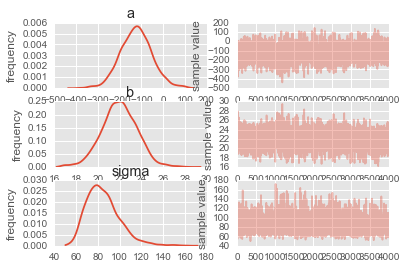

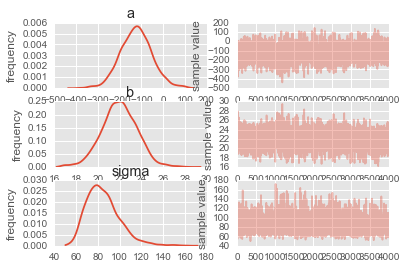

In [12]:
fit.plot()

#TODO chain毎にplotの色変える、グラフの重なりをなくす 

### 4.4.9 MCMCの設定変更

In [30]:
stanmodel = pystan.StanModel(file='input/model4-5.stan')

In [31]:
fit_modified = stanmodel.sampling(data=stan_data, pars=["b", "sigma"], 
                                   init=lambda: {"a":np.random.uniform(-10,10, 1)[0],"b":np.random.uniform(-10,10,1)[0], "sigma":10},seed=123, chains=3, iter=1000,warmup=200, thin=2)

In [32]:
fit_modified

Inference for Stan model: anon_model_b434bb1e5d9d51500bfdc976c8c173bc.
3 chains, each with iter=1000; warmup=200; thin=2; 
post-warmup draws per chain=400, total post-warmup draws=1200.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b      21.83    0.09   1.59   18.5  20.84  21.79  22.88  24.86    289    1.0
sigma  85.12    0.91  15.24  61.28  74.78   83.2  93.07 121.22    282    1.0
lp__  -93.63    0.08   1.26 -97.04 -94.24 -93.31  -92.7 -92.14    261    1.0

Samples were drawn using NUTS(diag_e) at Tue Nov  8 23:54:39 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

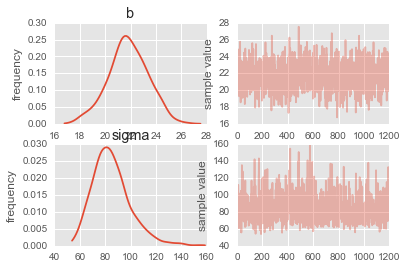

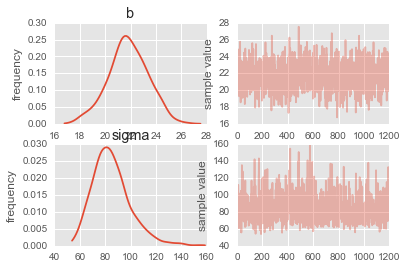

In [33]:
fit_modified.plot()

In [34]:
# コンパイルを省くためにモデル保存
import pickle
with open("tmp/4-4-9stanmodel.model", "wb") as f:
    pickle.dump(stanmodel, f)

#### 4.4.11 ベイズ信頼区間とベイズ予測区間の算出

In [13]:
ms = fit.extract()

In [14]:
ms["b"] # warmup期間はあらかじめ取り除き、MCMCサンプルを混ぜて並び替えたもの

array([ 19.5591921 ,  23.22101188,  23.17984651, ...,  19.5506656 ,
        21.54689547,  23.18543629])

In [15]:
np.percentile(ms["b"],[2.5,97.5])

array([ 18.72960419,  25.10164668])

In [16]:
d_mcmc = pd.DataFrame({"a":ms["a"], "b":ms["b"], "sigma":ms["sigma"]})

In [17]:
d_mcmc.head(2)

,a,b,sigma
0,-81.091257,19.559192,109.728884
1,-197.049822,23.221012,77.374026


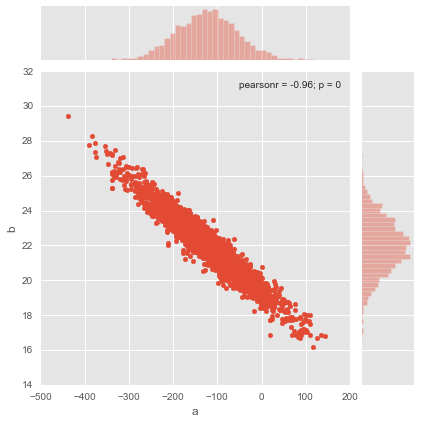

In [18]:
sns.jointplot(x="a", y="b",data=d_mcmc)

In [19]:
N_mcmc = len(ms["lp__"])
y50_base = ms["a"] + ms["b"] * 50

In [20]:
y50_base

array([ 896.86834801,  964.00077207,  987.34755959, ...,  955.4625731 ,
        969.36258588,  978.22038508])

In [21]:
y50 = np.random.normal(y50_base, ms["sigma"], size=N_mcmc)

In [22]:
d_mcmc = pd.DataFrame({"a":ms["a"], "b":ms["b"], "sigma":ms["sigma"], "y50_base":y50_base, "y50":y50})

In [23]:
d_mcmc.head(2)

,a,b,sigma,y50,y50_base
0,-81.091257,19.559192,109.728884,902.491541,896.868348
1,-197.049822,23.221012,77.374026,916.770644,964.000772


#### 信頼区間50, 95%算出

In [24]:
X_new = np.arange(23,60)
y_new = ms["a"] + ms["b"] * X_new[:, np.newaxis]
y_med = [np.median(_y) for _y in y_new]

conf_low_95 = []
conf_upp_95 = []
conf_low_50 = []
conf_upp_50 = []
for _x, _y in zip(X_new, y_new):
    pred_95 = np.percentile(_y,[2.5,97.5])
    pred_50 = np.percentile(_y,[25,75])
    conf_low_95.append(pred_95[0])
    conf_upp_95.append(pred_95[1])
    conf_low_50.append(pred_50[0])
    conf_upp_50.append(pred_50[1])
    

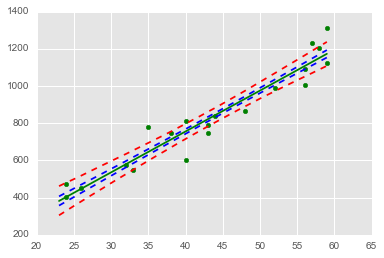

In [25]:
plt.plot(X_new, y_med, '-', color='g')
plt.plot(X_new, conf_low_95, '--', color='r')
plt.plot(X_new, conf_upp_95, '--', color='r')
plt.plot(X_new, conf_low_50, '--', color='b')
plt.plot(X_new, conf_upp_50, '--', color='b')
plt.scatter(X, y, color='g')

#### 予測区間50, 95%算出

In [26]:
# mu=y_base, sigma=sigmaの正規分布よりサンプリング
pred_low_95 = []
pred_upp_95 = []
pred_low_50 = []
pred_upp_50 = []
for _y in y_new:
    y_sample = np.random.normal(_y, ms["sigma"], size=N_mcmc)
    pred_95 = np.percentile(y_sample,[2.5,97.5])
    pred_50 = np.percentile(y_sample,[25,75])
    pred_low_95.append(pred_95[0])
    pred_upp_95.append(pred_95[1])
    pred_low_50.append(pred_50[0])
    pred_upp_50.append(pred_50[1])

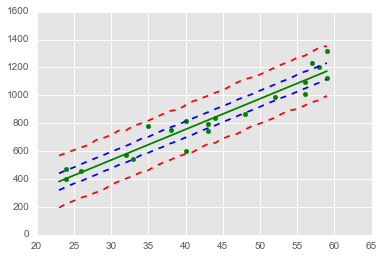

In [27]:
plt.plot(X_new, y_med, '-', color='g')
plt.plot(X_new, pred_low_95, '--', color='r')
plt.plot(X_new, pred_upp_95, '--', color='r')
plt.plot(X_new, pred_low_50, '--', color='b')
plt.plot(X_new, pred_upp_50, '--', color='b')
plt.scatter(X, y, color='g')

#### 4.4.12 transformed parameters ブロックとgenerated quantitiesブロック

In [39]:
stan_data_new = {'N':N, 'X':X, 'Y': y, "N_new": len(X_new), "X_new":X_new}
fit_new = pystan.stan(file='input/model4-5-new.stan', data=stan_data_new, seed=1234)

In [40]:
ms_new = fit_new.extract()

In [45]:
ms_new["y_new"][:,:4]

array([[ 259.52682068,  116.47983111,  479.66986624,  133.38347767],
       [ 361.47990482,  367.79935664,  569.26136827,  455.14365966],
       [ 412.38092975,  517.57109176,  364.08076871,  609.67027982],
       ..., 
       [ 478.94176541,  358.73539349,  469.45797582,  421.3915409 ],
       [ 382.15017057,  423.87727412,  429.77479057,  484.09284028],
       [ 402.34453751,  478.26127332,  410.33428334,  542.4903747 ]])

In [47]:
y_base = ms_new["y_base"]
y_new = ms_new["y_new"]
y_base_new = ms_new["y_base_new"]

In [55]:
# 信用区間
conf_low_95 = []
conf_upp_95 = []
conf_low_50 = []
conf_upp_50 = []
for _x, _y in zip(X_new, y_base_new.T):
    pred_95 = np.percentile(_y,[2.5,97.5])
    pred_50 = np.percentile(_y,[25,75])
    conf_low_95.append(pred_95[0])
    conf_upp_95.append(pred_95[1])
    conf_low_50.append(pred_50[0])
    conf_upp_50.append(pred_50[1])

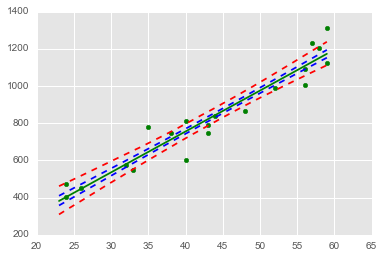

In [56]:
plt.plot(X_new, y_med, '-', color='g')
plt.plot(X_new, conf_low_95, '--', color='r')
plt.plot(X_new, conf_upp_95, '--', color='r')
plt.plot(X_new, conf_low_50, '--', color='b')
plt.plot(X_new, conf_upp_50, '--', color='b')
plt.scatter(X, y, color='g')

In [57]:
#　予測区間
# mu=y_base, sigma=sigmaの正規分布よりサンプリング
pred_low_95 = []
pred_upp_95 = []
pred_low_50 = []
pred_upp_50 = []
for _y in y_new.T:
    y_sample = np.random.normal(_y, ms["sigma"], size=N_mcmc)
    pred_95 = np.percentile(y_sample,[2.5,97.5])
    pred_50 = np.percentile(y_sample,[25,75])
    pred_low_95.append(pred_95[0])
    pred_upp_95.append(pred_95[1])
    pred_low_50.append(pred_50[0])
    pred_upp_50.append(pred_50[1])

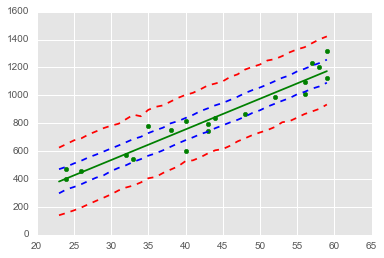

In [58]:
plt.plot(X_new, y_med, '-', color='g')
plt.plot(X_new, pred_low_95, '--', color='r')
plt.plot(X_new, pred_upp_95, '--', color='r')
plt.plot(X_new, pred_low_50, '--', color='b')
plt.plot(X_new, pred_upp_50, '--', color='b')
plt.scatter(X, y, color='g')

In [61]:
ms_new["y_new"][:,:4]

array([[ 259.52682068,  116.47983111,  479.66986624,  133.38347767],
       [ 361.47990482,  367.79935664,  569.26136827,  455.14365966],
       [ 412.38092975,  517.57109176,  364.08076871,  609.67027982],
       ..., 
       [ 478.94176541,  358.73539349,  469.45797582,  421.3915409 ],
       [ 382.15017057,  423.87727412,  429.77479057,  484.09284028],
       [ 402.34453751,  478.26127332,  410.33428334,  542.4903747 ]])

#### 練習問題